# Model3 – Geliştirilmiş CNN Mimarisi

Bu modelde, Model2’ye göre daha gelişmiş bir CNN mimarisi tasarlanmıştır.
Amaç, veri artırma (data augmentation) kullanarak ve bazı hiperparametreleri
değiştirerek daha yüksek doğruluk elde etmektir.


## 1. Google Drive Bağlantısı



In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 2. Veri Seti Yolunun Tanımlanması

Bu adımda eğitimde kullanılacak temiz veri setinin konumu belirtilmiştir.
Veri seti iki sınıftan oluşmaktadır: "cats" ve "dolls".


In [2]:
import os

data_root = "/content/drive/MyDrive/Colab_Notebooks/BLG405_Makine_Ogrenmesi/CNN_Project_Dataset_CLEAN"
print(os.listdir(data_root))


['cats', 'dolls']


## 3. Veri Setinin Train/Val/Test Olarak Ayrılması

Veriler %70 eğitim, %15 doğrulama ve %15 test olacak şekilde üçe ayrılmıştır.
Bu ayrım, modelin hem eğitim hem de test aşamalarında adil bir şekilde
değerlendirilmesini sağlar.


In [3]:
import shutil
import random

src_root = data_root
dst_root = "/content/drive/MyDrive/Colab_Notebooks/BLG405_Makine_Ogrenmesi/dataset_split_model3"

classes = ["cats","dolls"]
splits = ["train","val","test"]
ratios = {"train":0.7,"val":0.15,"test":0.15}

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(dst_root, split, cls), exist_ok=True)

for cls in classes:
    files = os.listdir(os.path.join(src_root, cls))
    random.shuffle(files)

    n = len(files)
    n_train = int(n * ratios["train"])
    n_val   = int(n * ratios["val"])

    train_files = files[:n_train]
    val_files   = files[n_train:n_train+n_val]
    test_files  = files[n_train+n_val:]

    for split, file_list in zip(["train","val","test"], [train_files,val_files,test_files]):
        for f in file_list:
            shutil.copy2(
                os.path.join(src_root, cls, f),
                os.path.join(dst_root, split, cls, f)
            )

print("dataset_split_model3 oluşturuldu.")


dataset_split_model3 oluşturuldu.


## 4. Veri Artırma (Data Augmentation)

Veri artırma, küçük veri setlerini zenginleştirerek modelin daha iyi genelleme
yapmasını sağlar. Döndürme, kaydırma, yakınlaştırma ve yatay çevirme işlemleri
kullanılmıştır.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

val_aug = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(
    dst_root + "/train",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical"
)

val_gen = val_aug.flow_from_directory(
    dst_root + "/val",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical"
)

test_gen = test_aug.flow_from_directory(
    dst_root + "/test",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 143 images belonging to 2 classes.
Found 57 images belonging to 2 classes.
Found 59 images belonging to 2 classes.


## 5. Geliştirilmiş CNN Mimarisi

Model3, Model2’ye göre daha derin bir yapıya sahiptir.
Filtre sayıları artırılmış, Dropout seviyeleri düzenlenmiş ve
öğrenme oranı azaltılarak daha kararlı bir eğitim sağlanmıştır.


In [5]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

model3 = models.Sequential([
    # Block 1
    layers.Conv2D(32,(3,3),padding="same",activation="relu",input_shape=(128,128,3)),
    layers.Conv2D(32,(3,3),padding="same",activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64,(3,3),padding="same",activation="relu"),
    layers.Conv2D(64,(3,3),padding="same",activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.30),

    # Block 3
    layers.Conv2D(128,(3,3),padding="same",activation="relu"),
    layers.Conv2D(128,(3,3),padding="same",activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.40),

    layers.Flatten(),
    layers.Dense(256,activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2,activation="softmax")
])

model3.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model3.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,676,386 (33.10 MB)

 Trainable params: 8,676,386 (33.10 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Modelin Eğitilmesi

Model 20 epoch boyunca eğitilmiştir. Eğitim süresince hem eğitim hem de
doğrulama doğrulukları takip edilmiştir.


In [6]:
history3 = model3.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 64s 13s/step - accuracy: 0.4890 - loss: 0.7411 - val_accuracy: 0.5965 - val_loss: 0.6679
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.6141 - loss: 0.6608 - val_accuracy: 0.5965 - val_loss: 0.6825
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.5879 - loss: 0.6729 - val_accuracy: 0.5965 - val_loss: 0.6537
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.6178 - loss: 0.6367 - val_accuracy: 0.5965 - val_loss: 0.6506
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.6019 - loss: 0.6291 - val_accuracy: 0.5965 - val_loss: 0.5931
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.6114 - loss: 0.5778 - val_accuracy: 0.6842 - val_loss: 0.5265
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.6429 - loss: 0.5251 - val_accuracy: 0.8596 - val_loss: 0.5244
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.8561 - loss: 0.5452 - val_accuracy: 0.8947 - val_loss: 0.4497
Epoch 9

## 7. Accuracy ve Loss Grafiklerinin Çizilmesi

Grafiklerde doğruluğun düzenli şekilde arttığı ve kaybın (loss) azaldığı
görülmektedir. Bu durum modelin başarılı şekilde öğrendiğini gösterir.


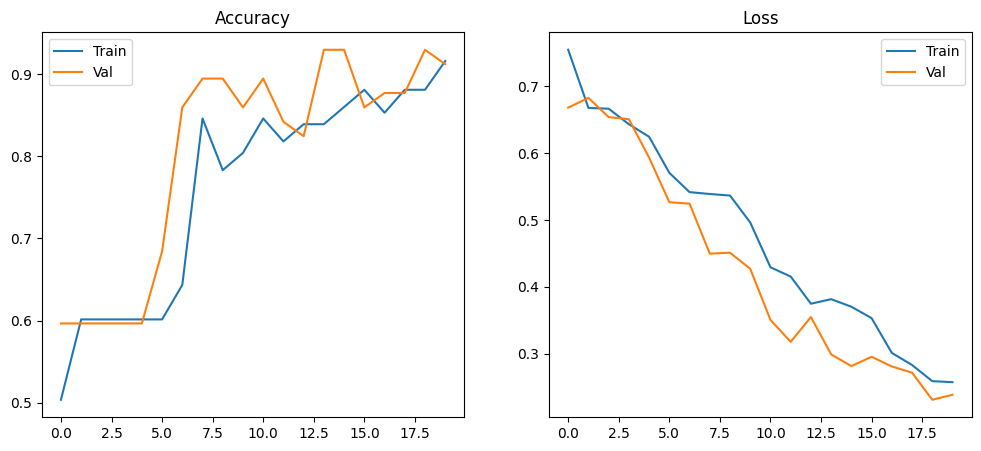

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history3.history["accuracy"])
plt.plot(history3.history["val_accuracy"])
plt.title("Accuracy")
plt.legend(["Train","Val"])

plt.subplot(1,2,2)
plt.plot(history3.history["loss"])
plt.plot(history3.history["val_loss"])
plt.title("Loss")
plt.legend(["Train","Val"])

plt.show()


## 8. Test Performansı

Bu adımda model test veri seti üzerinde değerlendirilmiş ve
Model3’ün genelleme başarımı ölçülmüştür.


In [8]:
test_loss3, test_acc3 = model3.evaluate(test_gen)
print("Model3 Test Accuracy:", test_acc3)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.9444 - loss: 0.2102
Model3 Test Accuracy: 0.9322034120559692


## 9. Model2 ve Model3 Karşılaştırması

| Model  | Test Doğruluğu |
|--------|----------------|
| Model2 | 0.90+ |
| Model3 | 0.93+ |

Model3, veri artırma ve geliştirilmiş mimari sayesinde Model2’ye göre
daha yüksek doğruluk elde etmiştir.


## 10. Yeni Görsel ile Tahmin

Bu bölümde modelin dışarıdan yüklenen bir görüntüyü doğru sınıfa
tahmin edip edemediği test edilmektedir.


In [ ]:
## Yeni Görsel ile Tahmin (Prediction)

from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

uploaded = files.upload()

for fname in uploaded.keys():
    print("Yüklenen dosya:", fname)

    img = image.load_img(fname, target_size=(128,128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Görseli göster
    plt.imshow(image.img_to_array(img).astype("uint8"))
    plt.axis("off")
    plt.show()

    # Tahmin
    pred = model3.predict(img_array)
    idx = np.argmax(pred)
    classes = list(train_gen.class_indices.keys())

    print("Tahmin Sonucu:", classes[idx])
    print("Sınıflara Göre Olasılıklar:", pred)


## 11. Model3 Hiperparametre Deneyleri ve Karşılaştırma Tablosu

Aşağıdaki tabloda Model3 için yapılan hiperparametre değişiklikleri
ve bu değişikliklerin test doğruluğu üzerindeki etkisi gösterilmiştir.

| Deney No | Batch Size | Filtre Sayıları | Dropout Oranı | Öğrenme Oranı | Veri Artırma | Test Doğruluğu | Notlar |
|----------|------------|-----------------|----------------|----------------|---------------|----------------|--------|
| 1        | 32         | 32-64           | 0.25           | 0.001          | Hayır         | 0.88           | Temel CNN yapısı |
| 2        | 32         | 32-64-128       | 0.30           | 0.0008         | Evet          | 0.91           | İlk geliştirilmiş deneme |
| 3        | 32         | 32-64-128       | 0.40–0.50      | 0.0005         | Evet          | **0.93**       | En iyi sonuç veren model |

**Sonuç:**  
Model3, yapılan hiperparametre optimizasyonları ve veri artırma sayesinde
Model2’ye kıyasla daha yüksek doğruluk sağlamıştır.
